# 1. Training a Tree-based Model (XGBoost)



##  1.1 Data Import

#### Import data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

# Read data that was exported from previous session
df_tree = pd.read_csv("../data/2-intermediate/df_out_dsif3_tree.csv")
df_tree.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,...,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Joint App,hardship_status_BROKEN,hardship_status_COMPLETE,hardship_status_COMPLETED,hardship_status_No Hardship
0,8.294300,8.294300,8.294300,36,0.122925,4.912140,10.778977,3.056357,1.0,6.501290,...,False,False,False,False,False,False,False,False,False,True
1,10.085851,10.085851,10.085851,60,0.087645,6.216746,10.950824,3.270709,0.0,6.523562,...,False,False,False,False,False,False,False,False,False,True
2,8.517393,8.517393,8.517393,36,0.099755,5.096752,10.915107,2.106570,0.0,6.501290,...,False,False,False,False,False,False,False,False,False,True
3,10.085851,10.085851,10.085851,60,0.104810,6.260384,10.680539,3.240637,0.0,6.621406,...,False,False,False,False,False,False,False,False,False,True
4,9.546884,9.546884,9.546884,60,0.127425,5.780095,10.778977,3.230804,0.0,6.601230,...,False,False,False,False,False,False,False,False,False,True


Do notice that we have logged most of the columns here.

In [2]:
df_tree['loan_default'].value_counts()

loan_default
0    84965
1    12578
Name: count, dtype: int64

Since XGBoost benefits more from natural variation and can probably handle class imbalance, I won't be using SMOTE for now. But I will be assigning higher weight on the minority class.

In [3]:
X = df_tree.drop('loan_default', axis=1)
y = df_tree['loan_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

## 1.2 Initial Training

In [4]:
scale_pos_weight = df_tree['loan_default'].value_counts()[0] / df_tree['loan_default'].value_counts()[1]

model = XGBClassifier(scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [5]:
# Generate classification report
report = classification_report(y_test, y_pred, digits=4)
print("🔍 Classification Report:\n")
print(report)

🔍 Classification Report:

              precision    recall  f1-score   support

           0     0.9975    0.9998    0.9986     16912
           1     0.9984    0.9838    0.9911      2597

    accuracy                         0.9976     19509
   macro avg     0.9980    0.9918    0.9949     19509
weighted avg     0.9976    0.9976    0.9976     19509



In [ ]:
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n📈 ROC AUC Score: {auc:.4f}")


📈 ROC AUC Score: 0.9993


This is suspiciously too good. Perhaps future leaks or some sort of overfitting. We shall be using some of the complexity reducer RFE and check what could potentially be a future leak. Finally, we may increase regularisation parameter.

In [ ]:
from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import StratifiedKFold

# Initialize base model
model = XGBClassifier(scale_pos_weight=scale_pos_weight,  eval_metric='logloss')

# Setup RFECV (recursive feature elimination with cross-validation)
rfecv = RFECV(
    estimator=model,
    step=5,                    # remove 1 feature per iteration
    cv=StratifiedKFold(3),
    scoring='roc_auc',
    min_features_to_select=20,
    verbose=1,
    n_jobs=-1
)

# Fit RFECV
rfecv.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfecv.support_].tolist()

print(f"\n Selected {len(selected_features)} features:\n", selected_features)

# Re-train final model with selected features
model_final = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
model_final.fit(X_train[selected_features], y_train)

# Evaluate
y_pred = model_final.predict(X_test[selected_features])
y_proba = model_final.predict_proba(X_test[selected_features])[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# CM
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


KeyboardInterrupt: 

Most of these data are only known after issuing the loan so it is somewhat of a future leak which we shall remove.

In [31]:
leakage_cols = [
    'total_rec_late_fee',
    'total_rec_prncp',
    'out_prncp',
    'last_pymnt_amnt',
    'last_pymnt_d',
    'funded_amnt_inv',
    'funded_amnt',
    'out_prncp_inv',
    'total_pymnt',
    'total_pymnt_inv',
    'last_pymnt_d_days',
    'last_credit_pull_d_days',
    'issue_d_days',
    'total_rec_int',
]
df_tree.drop(columns=leakage_cols, inplace=True, errors='ignore')

X = df_tree.drop('loan_default', axis=1)
y = df_tree['loan_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [36]:
model = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss')
rfe = RFE(estimator=model, n_features_to_select=20, step=1)

rfe.fit(X_train, y_train)
selected_features = X_train.columns[rfe.support_]
print("Exactly 20 features selected:", selected_features)

# Re-train final model with selected features
model_final = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
model_final.fit(X_train[selected_features], y_train)

# Evaluate
y_pred = model_final.predict(X_test[selected_features])
y_proba = model_final.predict_proba(X_test[selected_features])[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

Exactly 20 features selected: Index(['loan_amnt', 'term', 'installment', 'annual_inc', 'dti',
       'fico_range_low', 'revol_util', 'last_fico_range_high', 'open_il_12m',
       'max_bal_bc', 'inq_fi', 'total_cu_tl', 'num_bc_tl', 'pct_tl_nvr_dlq',
       'emp_length_num', 'earliest_cr_line_days', 'hardship_status_BROKEN',
       'hardship_status_COMPLETE', 'hardship_status_COMPLETED',
       'hardship_status_No Hardship'],
      dtype='object')

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     16912
           1       0.60      0.87      0.71      2597

    accuracy                           0.91     19509
   macro avg       0.79      0.89      0.83     19509
weighted avg       0.93      0.91      0.91     19509

ROC AUC Score: 0.9480


c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:28:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


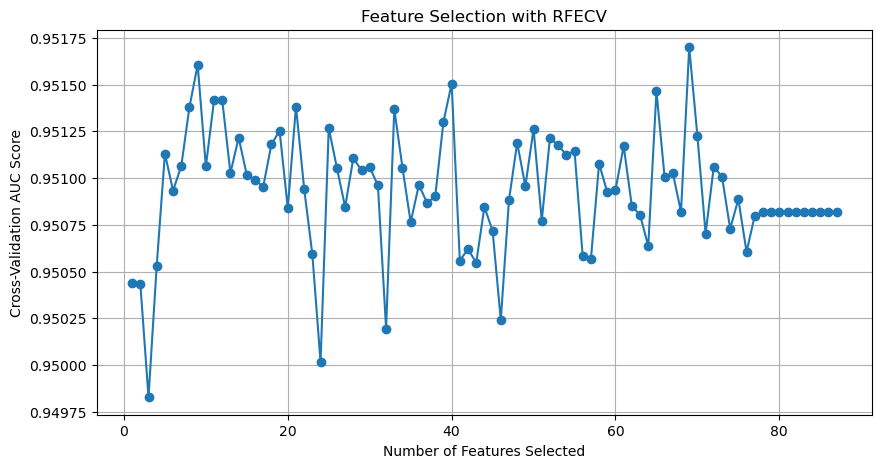

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation AUC Score")
plt.title("Feature Selection with RFECV")
plt.grid(True)
plt.show()

C:\Users\U-ser\AppData\Local\Temp\ipykernel_30164\2368005886.py:19: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


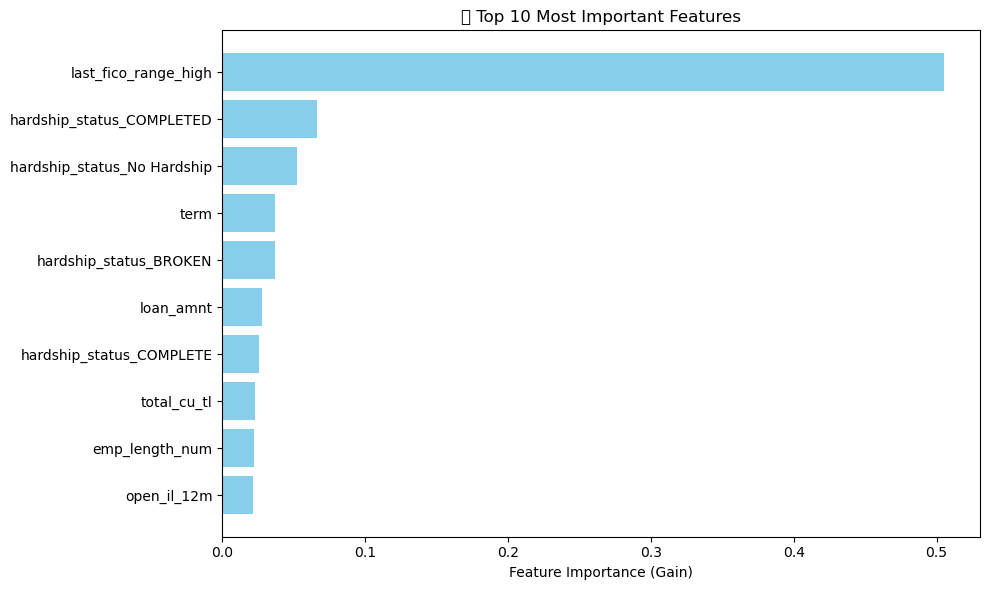

In [38]:
# Get feature importances from trained model (based on gain)
importances = model_final.feature_importances_
feature_names = X_train[selected_features].columns

# Create a DataFrame for easy sorting
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort and get top 10
top_feats = feat_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_feats['Feature'][::-1], top_feats['Importance'][::-1], color='skyblue')
plt.xlabel("Feature Importance (Gain)")
plt.title("🔍 Top 10 Most Important Features")
plt.tight_layout()
plt.show()

## 1.3 Hyperparameter tuning

In [42]:
from sklearn.model_selection import RandomizedSearchCV

xgb_base = XGBClassifier(
    eval_metric='logloss', 
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=78
)

param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'gamma': [0, 1, 5],
}

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=20,               
    scoring='roc_auc',       
    cv=StratifiedKFold(3),   
    verbose=1,
    n_jobs=-1,               
    random_state=22          
)

X_selected = X[selected_features]

X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=22)

In [43]:
random_search.fit(X_train_selected, y_train)

print("Best score (AUC):", random_search.best_score_)
print("Best params:", random_search.best_params_)

# Extract best model
best_model_tree = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:49:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best score (AUC): 0.9575622338308912
Best params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5}



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     16912
           1       0.57      0.91      0.70      2597

    accuracy                           0.90     19509
   macro avg       0.78      0.90      0.82     19509
weighted avg       0.93      0.90      0.91     19509


Test ROC AUC: 0.9530


<Axes: >

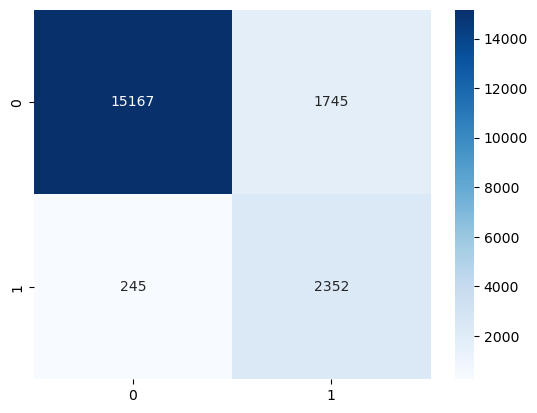

In [86]:
y_pred_test = best_model.predict(X_test_selected)
y_proba_test = best_model.predict_proba(X_test_selected)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

auc_test = roc_auc_score(y_test, y_proba_test)
print(f"\nTest ROC AUC: {auc_test:.4f}")

# CM
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

From the classification report and AUC:

Class 1 (Default):

Recall ≈ 0.91 means you’re catching about 91% of actual defaulters. This is good if your top priority is avoiding false negatives (i.e., not missing potential defaulters).

Precision ≈ 0.57 indicates that among the loans you predict as default, 57% actually default. So have some false positives, but that might be acceptable if identifying real defaulters is more critical.

Class 0 (Non-Default):

The model is still doing well here, but you are occasionally labeling good loans as riskier than they are (precision for 0 is high at 0.98, but recall is 0.90, meaning some non-defaulters are flagged).

AUC of 0.953 is excellent, suggesting the model does a strong job separating defaulters from non-defaulters overall.

## 1.4 Interpreting the model using SHAP

In [47]:
import shap

explainer = shap.TreeExplainer(best_model_tree)
shap_values = explainer.shap_values(X_test_selected)

# Expected value = average model output (baseline)
expected_value = explainer.expected_value
expected_value

-0.0023752134

IntSlider(value=2, description='Observation:', max=19)

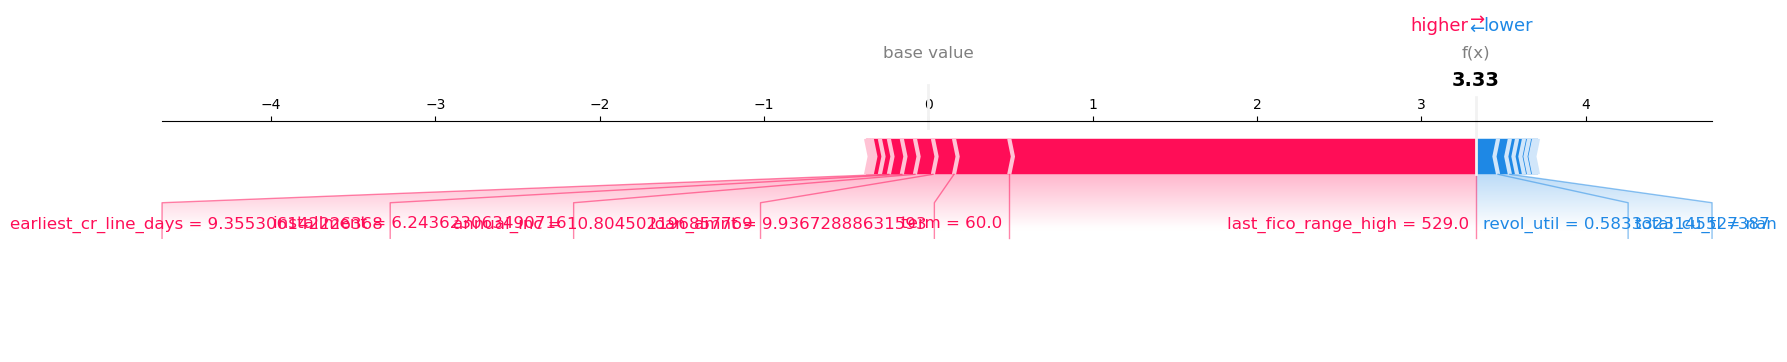

None

In [ ]:
from IPython.display import display, clear_output
import ipywidgets as widgets

# Initialize SHAP's JavaScript visualization
shap.initjs()

# We'll allow the user to pick from the first N rows of X_test_selected
N = 20  # or however many you want to display in your slider
max_index = min(len(X_test_selected), N) - 1

def update_shap_plot(observation_index):
    # Clear the previous output to avoid stacking
    clear_output(wait=True)
    display(observation_slider)

    # Force plot for the selected row
    display(shap.force_plot(
        base_value=expected_value,               # baseline model output
        shap_values=shap_values[observation_index], 
        features=X_test_selected.iloc[observation_index],
        feature_names=X_test_selected.columns,
        matplotlib=True
    ))

# Create a slider to select the row index from 0..max_index
observation_slider = widgets.IntSlider(
    value=0, min=0, max=max_index, step=1,
    description='Observation:', continuous_update=True
)

# Whenever the slider changes, update the shap plot
def slider_changed(change):
    if change['name'] == 'value':
        update_shap_plot(change['new'])

observation_slider.observe(slider_changed, names='value')

# Display the slider, then the initial SHAP plot
display(observation_slider)
update_shap_plot(0)

In [50]:
# Save the model
import joblib

joblib.dump(best_model_tree, "models/xgb_model_tree.pkl")

['models/xgb_model_tree.pkl']

In [ ]:
# Write selected features to a file and add a note
selected_features = X_selected.columns.to_list()
with open("models/selected_features_tree.txt", "w") as f:
    for item in selected_features:
        f.write("%s\n" % item)
    f.write("\n# Features selected using XGBoost (Some of these features are in Log scale. Refer to notebook 03 for more details.)")

# 2. Training a NN-based model (Challenger Model)

## 2.1 Data Import

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

df_nn = pd.read_csv("../data/2-intermediate/df_out_dsif3_nn.csv")
df_nn.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,mths_since_recent_bc_NA,mths_since_recent_inq_NA,mths_since_recent_revol_delinq_NA,num_tl_120dpd_2m_NA,pct_tl_nvr_dlq_NA,percent_bc_gt_75_NA,emp_length_num_NA,last_pymnt_d_days_NA,no_income,dti_NA
0,8.294300,8.294300,8.294300,36,0.122925,4.912140,1,1,10.778977,1,...,1,0,0,0,0,1,0,0,0,0
1,10.085851,10.085851,10.085851,60,0.087645,6.216746,1,5,10.950824,1,...,0,0,1,0,0,0,0,0,0,0
2,8.517393,8.517393,8.517393,36,0.099755,5.096752,1,1,10.915107,0,...,0,0,1,0,0,0,0,0,0,0
3,10.085851,10.085851,10.085851,60,0.104810,6.260384,1,1,10.680539,0,...,0,0,1,0,0,0,1,0,0,0
4,9.546884,9.546884,9.546884,60,0.127425,5.780095,2,1,10.778977,1,...,0,0,1,0,0,0,0,0,0,0


In [66]:
# Adding columns with data leakage
leakage_cols.append('last_pymnt_d_days_NA')

# Remove columns with data leakage
df_nn.drop(columns=leakage_cols, inplace=True, errors='ignore')

# Split data
X = df_nn.drop('loan_default', axis=1)
y = df_nn['loan_default']

# Scale data
scaler = MinMaxScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)


## 2.2 Feature Selection using XGBoost top 20 important features.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=22)

xgb_model = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feature_names = X.columns

# Pair features with their importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by descending importance
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance_df.reset_index(drop=True, inplace=True)

# Show top 20
print(feature_importance_df.head(20))

c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:34:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                     Feature  Importance
0       last_fico_range_high    0.302113
1                       term    0.059180
2             open_acc_6m_NA    0.056474
3            hardship_status    0.042527
4                  loan_amnt    0.019453
5          emp_length_num_NA    0.015314
6                      grade    0.013809
7      mths_since_rcnt_il_NA    0.011184
8       pub_rec_bankruptcies    0.009627
9                 il_util_NA    0.009587
10               installment    0.009225
11            pct_tl_nvr_dlq    0.008704
12     earliest_cr_line_days    0.008549
13  mths_since_recent_inq_NA    0.008503
14            fico_range_low    0.007918
15          application_type    0.007847
16       num_rev_tl_bal_gt_0    0.007846
17                annual_inc    0.007629
18       num_tl_120dpd_2m_NA    0.007582
19                       dti    0.007580


In [68]:
N = 20
top_features = feature_importance_df['Feature'].head(N).tolist()
print(f"Selected top {N} features:\n", top_features)

Selected top 20 features:
 ['last_fico_range_high', 'term', 'open_acc_6m_NA', 'hardship_status', 'loan_amnt', 'emp_length_num_NA', 'grade', 'mths_since_rcnt_il_NA', 'pub_rec_bankruptcies', 'il_util_NA', 'installment', 'pct_tl_nvr_dlq', 'earliest_cr_line_days', 'mths_since_recent_inq_NA', 'fico_range_low', 'application_type', 'num_rev_tl_bal_gt_0', 'annual_inc', 'num_tl_120dpd_2m_NA', 'dti']


## 2.3 Model Training

In [70]:
X_reduced = X[top_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, 
    y, 
    test_size=0.2, 
    random_state=22
)

In [71]:
# Smote
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=123)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

scaler = MinMaxScaler()
X_train_smote_array = scaler.fit_transform(X_train_smote)
X_test_array = scaler.transform(X_test)

# Convert back to DataFrame if you need column names
X_train_smote_scaled = pd.DataFrame(X_train_smote_array, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_array, columns=X_train.columns)


In [79]:
# NN model - Feedforward Neural Network with l2 reg and additional layers
def build_and_train_nn(
    X_train, y_train,
    X_val, y_val,
    input_dim=None,          # In case you want to override
    lambda_l2=0.001,
    initial_lr=0.001,
    final_lr=1e-6,
    epochs=50,
    batch_size=32,
    patience=5
):
    """
    Builds and trains a 3-layer feedforward neural network
    with L2 regularization, exponential LR decay, early stopping,
    and binary crossentropy loss.

    Returns:
      model, history
    """
    # If no input_dim provided, infer from X_train
    if input_dim is None:
        input_dim = X_train.shape[1]

    # Learning rate schedule
    steps_per_epoch = int(len(X_train) / batch_size)
    learning_rate_decay_factor = (final_lr / initial_lr)**(1/50)
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=steps_per_epoch,
        decay_rate=learning_rate_decay_factor,
        staircase=True
    )
    opt = keras.optimizers.AdamW(learning_rate=lr_schedule)
    
    # Build the model
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(lambda_l2)))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(lambda_l2)))
    model.add(Dense(16, activation='relu', kernel_regularizer=l2(lambda_l2)))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile with binary crossentropy and relevant metrics
    model.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall', 'AUC']
    )

    # Early stopping: monitor precision on validation set
    early_stopping = EarlyStopping(
        monitor='val_precision',
        mode='max',
        patience=patience,
        restore_best_weights=True
    )
    
    # Fit the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    
    return model, history

In [ ]:
model_nn, history_nn = build_and_train_nn(
    X_train, y_train,
    X_test, y_test,     # pass test or separate val
    lambda_l2=0.001,
    initial_lr=0.001,
    final_lr=1e-6,
    epochs=50,
    batch_size=32,
    patience=5
)

Epoch 1/50


c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2439/2439 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - AUC: 0.8769 - Precision: 0.6420 - Recall: 0.5068 - accuracy: 0.9003 - loss: 0.2998 - val_AUC: 0.9383 - val_Precision: 0.8031 - val_Recall: 0.4617 - val_accuracy: 0.9133 - val_loss: 0.2081
Epoch 2/50
 182/2439 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - AUC: 0.9252 - Precision: 0.7443 - Recall: 0.5018 - accuracy: 0.9195 - loss: 0.2091

c:\Users\U-ser\anaconda3\envs\python_3_12_8\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_precision` which is not available. Available metrics are: AUC,Precision,Recall,accuracy,loss,val_AUC,val_Precision,val_Recall,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


2439/2439 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.9319 - Precision: 0.7412 - Recall: 0.5649 - accuracy: 0.9194 - loss: 0.2051 - val_AUC: 0.9366 - val_Precision: 0.7329 - val_Recall: 0.6465 - val_accuracy: 0.9216 - val_loss: 0.2035
Epoch 3/50
2439/2439 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.9362 - Precision: 0.7194 - Recall: 0.5997 - accuracy: 0.9197 - loss: 0.1989 - val_AUC: 0.9414 - val_Precision: 0.7262 - val_Recall: 0.6904 - val_accuracy: 0.9241 - val_loss: 0.1953
Epoch 4/50
2439/2439 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.9412 - Precision: 0.7218 - Recall: 0.6399 - accuracy: 0.9226 - loss: 0.1934 - val_AUC: 0.9406 - val_Precision: 0.8183 - val_Recall: 0.3935 - val_accuracy: 0.9076 - val_loss: 0.2453
Epoch 5/50
2439/2439 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - AUC: 0.9459 - Precision: 0.7270 - Recall: 0.6563 - accuracy: 0.9233 - loss: 0.1892 - val_AUC: 0.9442 - val_Precision: 0.7557 - val_Recall: 0.6122 - val_accuracy: 0.9220 - val_loss: 0.1938
Epoch 6/50
2439/2439 ━━━━━━━━━━━━━━

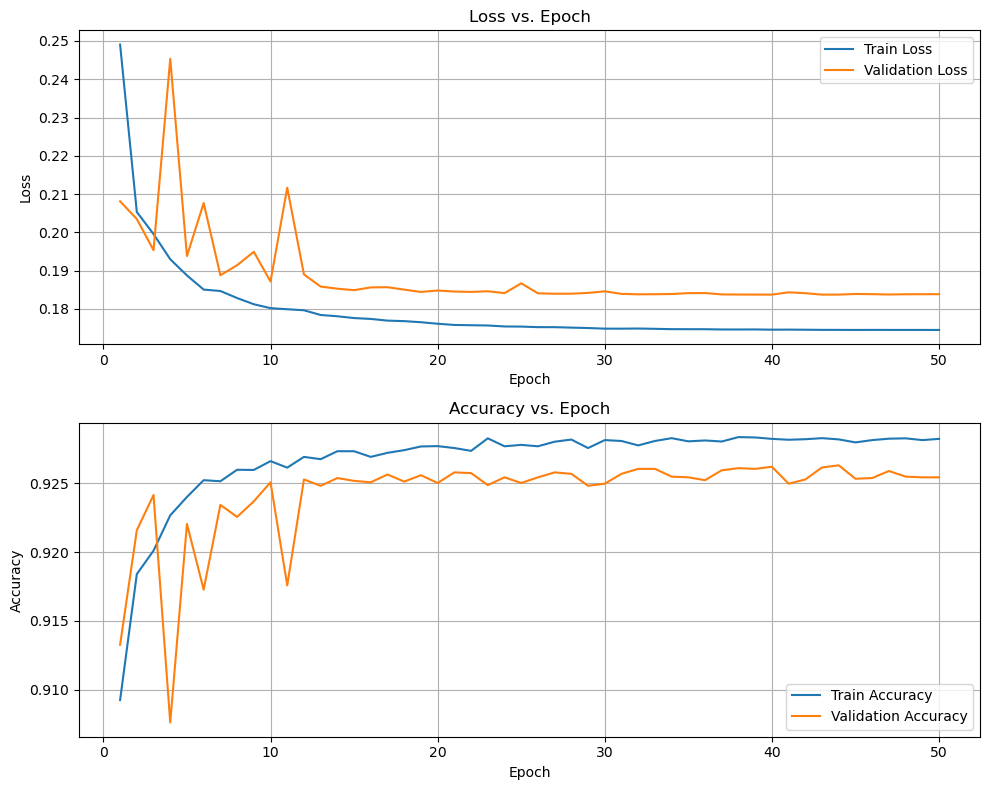

In [83]:
def plot_training_curves(history):
    """
    Plots training vs. validation loss and accuracy over epochs.
    """
    train_loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    train_acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    
    epochs = range(1, len(train_loss) + 1)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    # LOSS PLOT
    ax[0].plot(epochs, train_loss, label='Train Loss')
    ax[0].plot(epochs, val_loss, label='Validation Loss')
    ax[0].set_title('Loss vs. Epoch')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].grid(True)

    #  ACCURACY PLOT
    ax[1].plot(epochs, train_acc, label='Train Accuracy')
    ax[1].plot(epochs, val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy vs. Epoch')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_curves(history_nn)

610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     16912
           1       0.73      0.70      0.71      2597

    accuracy                           0.93     19509
   macro avg       0.84      0.83      0.84     19509
weighted avg       0.92      0.93      0.92     19509

ROC AUC: 0.8291


<Axes: >

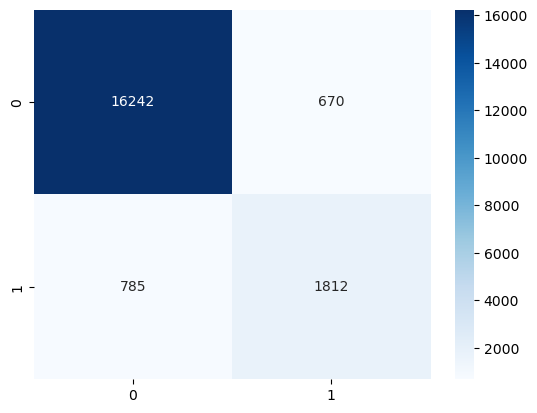

In [85]:
# Validation and test set predictions
y_pred_val = model_nn.predict(X_test)
y_pred_val = (y_pred_val > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred_val))

# ROC AUC
auc_val = roc_auc_score(y_test, y_pred_val)
print(f"ROC AUC: {auc_val:.4f}")

# CM
cm = confusion_matrix(y_test, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


It seems this model isn't as capable as our XGBoost in terms of its recall in the positive class (default). Meaning higher False Negative. So we will not implementing this model in our application until we further optimise this model resulting in a better result.

In [88]:
# Save the model
model_nn.save("models/nn_model.keras")

# Save the scaler
joblib.dump(scaler, "models/scaler_nn.pkl")

# Save the selected features
with open("models/selected_features_nn.txt", "w") as f:
    for item in top_features:
        f.write("%s\n" % item)
    f.write("\n# Features selected using XGBoost (Some of these features are in Log scale. Refer to notebook 03 for more details.) used for training the Neural Network model.")
